This notebook is meant to detail the procedure of outlier detection and removal. It is done only for your chosen class. For the full automatized process use the full_mislabeled_removel.py file!

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

import keras, keras.backend as K
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose

In [ ]:
# In this notebook the outlier removal is done class by class
current_class = 'wrl' # Change here your desired class. It's the name of the folder where the its images are kept.

In [2]:
# Define path to directory and set image size
# the image size has to match the input dimension of the loaded model

img_folder = 'Reduced_Dataset'
IMG_WIDTH = 128
IMG_HEIGHT = 128

# aux function
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
    file_list = []

    for dir1 in os.listdir(img_folder):
        if dir1 == '.DS_Store':
            print('Ignoring .DS_Store')
        else:
            for file in os.listdir(os.path.join(img_folder, dir1)):
                image_path = os.path.join(img_folder, dir1, file)
                image = cv2.imread(image_path)[:,:,::-1]
                image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                image = np.array(image)
                image = image.astype('float32')
                image /= 255
                img_data_array.append(image)
                class_name.append(dir1)
                file_list.append(file)
    return img_data_array, class_name, file_list

In [3]:
# extract the image array and class name
img_data, class_name, file_list = create_dataset(img_folder)

# Dictionary for class names
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}

# convert class_names to their values
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

# As array
X = np.asarray(img_data)
y = np.asarray(target_val)

Ignoring .DS_Store


In [5]:
# Loading Models
encoder = tf.keras.models.load_model('bug_encoder_128_encdim_32.h5')
decoder = tf.keras.models.load_model('bug_decoder_128_encdim_32.h5')

# Encode inputs with encoder
X_compressed = encoder.predict(X)

2022-11-10 11:10:27.388896: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# keep track of the indeces of the chosen class
bool_arr = (np.array(class_name) == current_class)

Epsilon =  3


Text(0, 0.5, 'Euclidean distance')

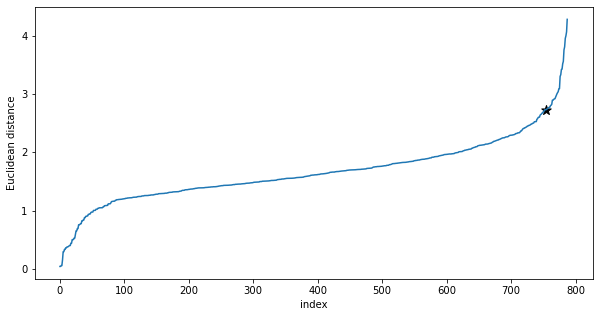

In [7]:
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# n_neighbors equal to the min points on dbscan, around 2*dimensionality of the data (encoding size)
NN = NearestNeighbors(n_neighbors=2*X_compressed.shape[-1])
NN_fit = NN.fit(X_compressed[bool_arr,:])
distances, indices = NN_fit.kneighbors(X_compressed[bool_arr,:])

# Sort distances and explore
distances = np.sort(distances, axis=0)
distances = distances[:,1]
elbow = KneeLocator(np.arange(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
epsilon = elbow.elbow_y

print('Epsilon = ', round(elbow.elbow_y))
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.scatter(elbow.elbow, elbow.elbow_y, marker = '*', color = 'k', s = 100)
plt.xlabel('index')
plt.ylabel('Euclidean distance')

We now apply DBSCAN with the value for epsilon previously found, and keeping min_samples as 2*dim_encoding. Only the instances in the encodings corresponding to the chosen class are selected. The idea is that the autoencoder learns features representitive of all the classes, and hence a mislabelled class should present itself as an outlier when selecting only encoded instances of one class.

In [8]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Only the instances in the encodings corresponding to the chosen class are selected.  
X_db = X_compressed[bool_arr,:] 

db = DBSCAN(eps=epsilon, min_samples=2*X_compressed.shape[-1]).fit(X_db)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 50


In [9]:
# identify which samples in original data are outliers and which are not
file_list_one_type = np.array(file_list)[bool_arr]
outlier_list = file_list_one_type[np.where(labels == -1)] # files to remove
clean_list = file_list_one_type[np.where(labels == 0)] # files to keep

#indeces of outliers in original file_list
bool_outliers = np.where(np.in1d(file_list, outlier_list))[0]

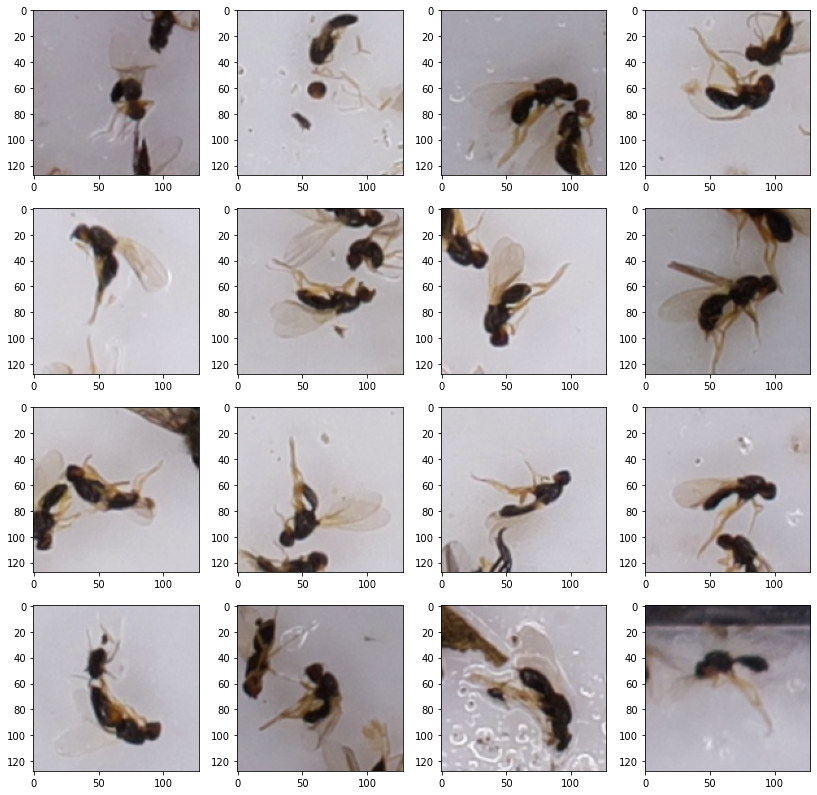

In [10]:
# Display some randomly chosen potential 'misslabeled' images
from numpy.random.mtrand import shuffle
shuffle(bool_outliers)
plt.figure(figsize=(14, 14))
if len(bool_outliers) < 17:
    disp_length = len(bool_outliers)
else:
    disp_length = 17

for i in range(1,disp_length):
  plt.subplot(4,4,i)
  plt.imshow(X[bool_outliers[i-1],:,:,:])

In [11]:
if not os.path.exists('Removed'):
    os.mkdir('Removed')

if not os.path.exists('Removed/' + current_class):
    os.mkdir('Removed/' + current_class)

if not os.path.exists('Cleaned_Data'):
    os.mkdir('Cleaned_Data')

if not os.path.exists('Cleaned_Data/' + current_class):
    os.mkdir('Cleaned_Data/' + current_class)

In [12]:
import shutil
# Filling Outlier folder
src = img_folder + '/' + current_class + '/'
dst = 'Removed/' + current_class + '/'
for file in outlier_list:
    shutil.copyfile(src + file, dst + file)

# Filling Clean Data folder
src = img_folder + '/' + current_class + '/'
dst = 'Cleaned_Data/' + current_class + '/'
for file in clean_list:
    shutil.copyfile(src + file, dst + file)
